In [1]:
import pandas as pd

#load in all the data and concatenate data frames
euro = pd.read_json('/Users/allisonjames/Desktop/DIS/big data/data/events/events_European_Championship.json')
england = pd.read_json('/Users/allisonjames/Desktop/DIS/big data/data/events/events_England.json')
france = pd.read_json('/Users/allisonjames/Desktop/DIS/big data/data/events/events_France.json')
germany = pd.read_json('/Users/allisonjames/Desktop/DIS/big data/data/events/events_Germany.json')
italy = pd.read_json('/Users/allisonjames/Desktop/DIS/big data/data/events/events_Italy.json')
spain = pd.read_json('/Users/allisonjames/Desktop/DIS/big data/data/events/events_Spain.json')
worldcup = pd.read_json('/Users/allisonjames/Desktop/DIS/big data/data/events/events_World_Cup.json')

euros = pd.concat([euro, england, france, germany, italy, spain, worldcup], axis=0) #make one large data frame


In [2]:
euros

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],26010,"[{'y': 48, 'x': 50}, {'y': 50, 'x': 47}]",1694390,Pass,4418,1H,1.255990,85,88178642
1,8,Simple pass,[{'id': 1801}],3682,"[{'y': 50, 'x': 47}, {'y': 48, 'x': 41}]",1694390,Pass,4418,1H,2.351908,85,88178643
2,8,Simple pass,[{'id': 1801}],31528,"[{'y': 48, 'x': 41}, {'y': 35, 'x': 32}]",1694390,Pass,4418,1H,3.241028,85,88178644
3,8,High pass,[{'id': 1802}],7855,"[{'y': 35, 'x': 32}, {'y': 6, 'x': 89}]",1694390,Pass,4418,1H,6.033681,83,88178645
4,1,Ground defending duel,"[{'id': 702}, {'id': 1801}]",25437,"[{'y': 6, 'x': 89}, {'y': 0, 'x': 85}]",1694390,Duel,4418,1H,13.143591,12,88178646
...,...,...,...,...,...,...,...,...,...,...,...,...
101754,8,Simple pass,[{'id': 1801}],3476,"[{'y': 20, 'x': 46}, {'y': 6, 'x': 64}]",2058017,Pass,9598,2H,2978.301867,85,263885652
101755,7,Touch,[],14812,"[{'y': 6, 'x': 64}, {'y': 2, 'x': 82}]",2058017,Others on the ball,9598,2H,2979.084611,72,263885653
101756,8,Cross,"[{'id': 401}, {'id': 801}, {'id': 1802}]",14812,"[{'y': 2, 'x': 82}, {'y': 100, 'x': 100}]",2058017,Pass,9598,2H,2983.448628,80,263885654
101757,4,Goalkeeper leaving line,[],25381,"[{'y': 0, 'x': 0}, {'y': 98, 'x': 18}]",2058017,Goalkeeper leaving line,4418,2H,2985.869275,40,263885613


In [3]:
import numpy as np



#DATA CLEANING AND FILTERING

euros_shots = euros[euros.eventName == "Shot"] #only want events that are shots for now
euros_shots = euros_shots.dropna()
#just grab the first position from the positions column (starting position)
starting = euros_shots['positions'].values
starting_pos = []
for index, s in enumerate(starting):
    starting_pos.append(list(starting[index][0].values())) #append the first x, y pair to a list

#y is first, then x
euros_shots['shot_pos'] = starting_pos #create a new column with y, x position in list format

In [4]:
#ADD COLUMN FOR TAGS -> CHECK WHETHER EACH SHOT IS A GOAL USING THE TAGS


og_tags = euros_shots['tags'].values

tags = []
is_goal=[]
for index, t in enumerate(og_tags):
    flag=False
    tags_list = og_tags[index]
    for val in tags_list: #iterate through the list of tags for each shot
        if val['id'] == 101:
            flag = True
            is_goal.append(1) #if one of the tags in the list is 101, that shot was a goal -> append 1 to list
    if not flag:
        is_goal.append(0) #otherwise, append a 0 to the list
        flag=False
euros_shots['is_goal'] = is_goal #create the new column for whether the shot is a goal

In [5]:
import math

#add a column for the distance of the shot to the goal
dist_center = []

post1_pos = 30.34 #position of the left post
post2_pos = 37.66 #position of the right post

for pos in euros_shots['shot_pos']:
    y_meters = pos[0]*.68 #convert y position to meters
    x_meters = pos[1]*1.05 #convert x position to meters
    dist_center.append(math.sqrt((105-x_meters)**2 + (34 - y_meters)**2)) #distance formula to center of the goal
    
euros_shots['dist_center'] = dist_center #create the new column

#add a column for the angle to the goal
angle_goal = []
for pos in euros_shots['shot_pos']:
    y_meters = pos[0]*.68
    x_meters = pos[1]*1.05
    dist_post1 = math.sqrt((105-x_meters)**2 + (post1_pos - y_meters)**2) #calculate distance to each post
    dist_post2 = math.sqrt((105-x_meters)**2 + (post2_pos - y_meters)**2)
    #angle_goal.append((dist_post2**2 + dist_post1**2 - 7.32**2)/(2*dist_post1*dist_post2))
    angle_goal.append(math.acos(max((dist_post2**2 + dist_post1**2 - 7.32**2)/(2*dist_post1*dist_post2), -1)) * (180/math.pi))
    #calculate angle to goal with law of cosines

euros_shots['angle_goal'] = angle_goal #create the new column

    

In [6]:
#Get name of player that took the shot and add to our data set

players = pd.read_json('/Users/allisonjames/Desktop/DIS/big data/data/events/players.json') #load in players data
players = players[['wyId', 'foot', 'lastName', 'firstName']] #get columns of data that's useful
players['name'] = players['firstName'] + " " + players['lastName'] #new column with entire name of player
players = players[['wyId', 'foot', 'name']]
players = players.rename(columns={'wyId': 'playerId'}) #rename column to match other data set


In [7]:
#left join players with the shots

euros_shots_joined = euros_shots.join(players.set_index('playerId'), on = 'playerId') #join the datasets

In [8]:
#make a column for whether the player shot with their weak foot

dom_foot = []
for index, t in enumerate(og_tags):
    flag=False
    tags_list = og_tags[index]
    for val in tags_list: #iterate through the tags again
        #tag for left footed shot is 401, right footed shot is 402
        if val['id'] == 401 and euros_shots_joined['foot'].iloc[index] == 'left': 
            flag = True
            dom_foot.append(1) #append 1 -> player is left footed and used left foot
        elif val['id'] == 402 and euros_shots_joined['foot'].iloc[index] == 'right':
            flag = True
            dom_foot.append(1) #append 1 -> player is right footed and used right foot
    if not flag:
        dom_foot.append(0) #player used their weak foot or other part of their body (such as their head)
        flag=False
        
        
euros_shots_joined['is_dom'] = dom_foot #add column to data set


In [9]:
#add whether shot is during a counter attack

counter = []
for index, t in enumerate(og_tags):
    flag=False
    tags_list = og_tags[index]
    for val in tags_list:
        if val['id'] == 1901: #1901 is the tag for a counter attack
            flag = True
            counter.append(1)
    if not flag:
        counter.append(0)
        flag=False

#append counter attacks to data set
euros_shots_joined['is_counter'] = counter #add column to dataset
euros_shots_joined


,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,shot_pos,is_goal,dist_center,angle_goal,foot,name,is_dom,is_counter
8,10,Shot,"[{'id': 402}, {'id': 1401}, {'id': 1203}, {'id...",25437,"[{'y': 29, 'x': 91}, {'y': 0, 'x': 0}]",1694390,Shot,4418,1H,31.226217,100,88178649,"[29, 91]",0,17.123694,13.885382,left,Blaise Matuidi,0,0
43,10,Shot,"[{'id': 402}, {'id': 201}, {'id': 1216}, {'id'...",83824,"[{'y': 29, 'x': 71}, {'y': 100, 'x': 100}]",1694390,Shot,11944,1H,143.119551,100,88178722,"[29, 71]",0,33.632141,11.277838,right,Mihai Doru Pintilii,1,0
59,10,Shot,"[{'id': 402}, {'id': 201}, {'id': 1201}, {'id'...",33235,"[{'y': 57, 'x': 96}, {'y': 100, 'x': 100}]",1694390,Shot,11944,1H,219.576026,100,88178751,"[57, 96]",0,6.348039,48.813019,right,Bogdan Sorin Stancu,1,0
69,10,Shot,"[{'id': 403}, {'id': 201}, {'id': 1215}, {'id'...",6165,"[{'y': 61, 'x': 96}, {'y': 100, 'x': 100}]",1694390,Shot,11944,1H,247.532561,100,88373458,"[61, 96]",0,8.578485,27.055300,right,Florin Andone,0,0
162,10,Shot,"[{'id': 401}, {'id': 2101}, {'id': 1802}]",3682,"[{'y': 33, 'x': 75}, {'y': 0, 'x': 0}]",1694390,Shot,4418,1H,557.319065,100,88178811,"[33, 75]",0,28.682679,13.356273,left,Antoine Griezmann,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101371,10,Shot,"[{'id': 101}, {'id': 402}, {'id': 201}, {'id':...",14943,"[{'y': 53, 'x': 92}, {'y': 100, 'x': 100}]",2058017,Shot,9598,2H,1389.182669,100,263885208,"[53, 92]",1,8.644166,45.075577,right,Mario Mand\u017euki\u0107,1,0
101457,10,Shot,"[{'id': 402}, {'id': 201}, {'id': 1211}, {'id'...",69409,"[{'y': 61, 'x': 65}, {'y': 100, 'x': 100}]",2058017,Shot,9598,2H,1802.299261,100,263885299,"[61, 65]",0,37.503505,10.929260,right,\u0160ime Vrsaljko,1,0
101493,10,Shot,"[{'id': 401}, {'id': 2101}, {'id': 1802}]",3476,"[{'y': 33, 'x': 81}, {'y': 100, 'x': 100}]",2058017,Shot,9598,2H,1933.996341,100,263885348,"[33, 81]",0,23.057235,15.737204,right,Ivan Rakiti\u0107,0,0
101620,10,Shot,"[{'id': 401}, {'id': 201}, {'id': 1204}, {'id'...",28115,"[{'y': 76, 'x': 78}, {'y': 0, 'x': 0}]",2058017,Shot,4418,2H,2487.443304,100,263885485,"[76, 78]",0,29.089386,11.477376,left,Nabil Fekir,1,0


In [29]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, precision_score

#CREATE LOGISTIC REGRESSION MODELS FOR THE DATA

#model for just distance and angle
features3=['dist_center', 'angle_goal'] #the features we are including in model
X3 = euros_shots_joined[features3]
y3 = euros_shots_joined['is_goal']


logreg3 = LogisticRegression()

# fit the model with data
logreg3.fit(X3,y3)

y_p_p3 = logreg3.predict_proba(X3)
y_3 = logreg3.predict(X3)

acc3 = logreg3.score(X3, y3)
print("Accuracy: ", acc3)
precision3 = precision_score(y3, y_3)
print("Precision: ", precision3)
recall3 = recall_score(y3, y_3)
print("Recall: ", recall3)

Accuracy:  0.8987418171688565
Precision:  0.6199261992619927
Recall:  0.07479964381121995


No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.763


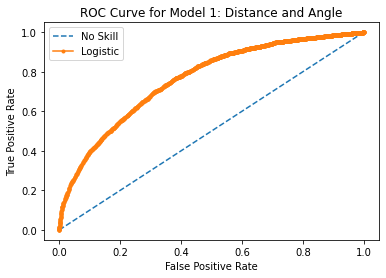

In [34]:
from sklearn.metrics import roc_curve, roc_auc_score
from matplotlib import pyplot

#MAKE ROC CURVES THE MODELS
ns_probs = [0 for _ in range(len(y2))]
# fit a model
# predict probabilities
lr_probs = logreg3.predict_proba(X3)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y3, ns_probs)
lr_auc = roc_auc_score(y3, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y3, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y3, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('ROC Curve for Model 1: Distance and Angle')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [32]:
#model for distance, angle, and dominant foot
features4=['dist_center', 'angle_goal', 'is_dom'] #the features we are including in model
X4 = euros_shots_joined[features4]
y4 = euros_shots_joined['is_goal']


logreg4 = LogisticRegression()

# fit the model with data
logreg4.fit(X4,y4)

y_p_p4 = logreg4.predict_proba(X4)
y_4 = logreg4.predict(X4)

acc4 = logreg4.score(X4, y4)
print("Accuracy: ", acc4)
precision4 = precision_score(y4, y_4)
print("Precision: ", precision4)
recall4 = recall_score(y4, y_4)
print("Recall: ", recall4)

Accuracy:  0.8997632202052092
Precision:  0.6435643564356436
Recall:  0.08682101513802315


In [10]:
#model for distance, angle, dominant foot, and counter attack
features=['dist_center', 'angle_goal', 'is_counter', 'is_dom'] #the features we are including in model
X = euros_shots_joined[features]
y = euros_shots_joined['is_goal']

logreg = LogisticRegression()

#fit the model with data
logreg.fit(X,y)
y_p_p=logreg.predict_proba(X) #probability of a shot being a goal
y_p= logreg.predict(X) #whether a shot will be a goal or not
acc = logreg.score(X, y)
print("Accuracy: ", acc)
precision = precision_score(y, y_p)
print("Precision: ", precision)
recall = recall_score(y, y_p)
print("Recall: ", recall)


#predictions says whether they think that shot will be a goal or not
#predict prob says the probability of that shot being a goal

Accuracy:  0.8996703653837226
Precision:  0.6280120481927711
Recall:  0.09283170080142475


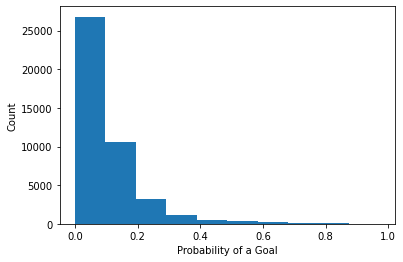

In [11]:
#create scatterplot of predictions based on this most detailed model

from matplotlib import pyplot as plt

prob_goal = []
for item in list(y_p_p):
    prob_goal.append(item[1])

plt.hist(prob_goal)
plt.xlabel('Probability of a Goal')
plt.ylabel('Count')
plt.show()


In [12]:
## export all the goal probabilities into a csv file
d = {"Probability": prob_goal}
df = pd.DataFrame(d)
df.to_csv('probs.csv')

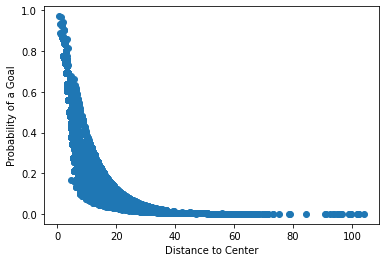

In [13]:
#Scatterplot for distance to goal vs goal probability
plt.scatter(dist_center, prob_goal)
plt.xlabel('Distance to Center')
plt.ylabel('Probability of a Goal')
plt.show()

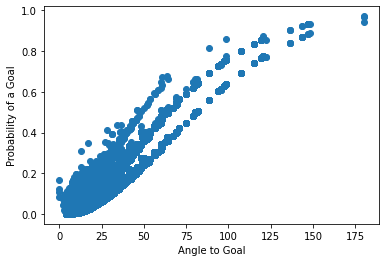

In [14]:
#Scatterplot for angle to goal vs goal probability
plt.scatter(angle_goal, prob_goal)
plt.xlabel('Angle to Goal')
plt.ylabel('Probability of a Goal')
plt.show()

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.774


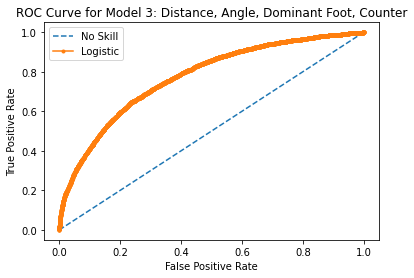

In [35]:
from sklearn.metrics import roc_curve, roc_auc_score
from matplotlib import pyplot

ns_probs = [0 for _ in range(len(y))]
# fit a model
# predict probabilities
lr_probs = logreg.predict_proba(X)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y, ns_probs)
lr_auc = roc_auc_score(y, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('ROC Curve for Model 3: Distance, Angle, Dominant Foot, Counter')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [16]:
#CREATE RANDOM FOREST

from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance


rf = RandomForestRegressor(n_estimators=100) #create 100 decision trees
rf.fit(X, y)

rf.feature_importances_

array([0.55621249, 0.33875285, 0.03743621, 0.06759844])

Text(0.5, 0, 'Random Forest Feature Importance')

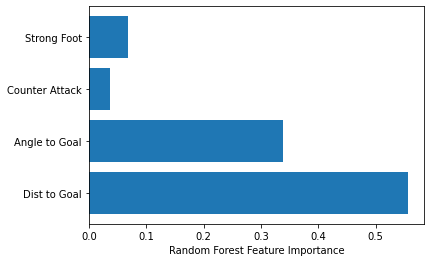

In [17]:
#plot the importance of each feature
feature_labels = ["Dist to Goal", "Angle to Goal", "Counter Attack", "Strong Foot"]

plt.barh(feature_labels, rf.feature_importances_)
plt.xlabel("Random Forest Feature Importance")

Text(0.5, 0, 'Random Forest Feature Importance')

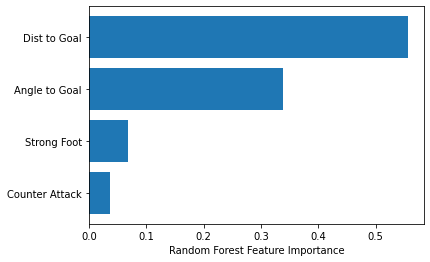

In [18]:
#sort the bar graph where the features are sorted
sorted_idx = rf.feature_importances_.argsort()
sorted_idx

plt.barh(np.array(feature_labels)[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

#ADD TITLE AND LABELS

In [19]:
#create specific columns for the y and x positions so that we can include those in our model
euros_shots_joined['y'] = [item[0] for item in starting_pos]
euros_shots_joined['x'] = [item[1] for item in starting_pos]

In [20]:
#create one last model that includes the x and y values of the shot itself (rather than just distance and angle)

features2=['dist_center', 'angle_goal', 'is_counter', 'is_dom', 'y', 'x'] #the features we are including in model
X2 = euros_shots_joined[features2]
y2 = euros_shots_joined['is_goal']


logreg2 = LogisticRegression()

# fit the model with data
logreg2.fit(X2,y2)

y_p_p2 = logreg2.predict_proba(X2)
y_2 = logreg2.predict(X2)

acc2 = logreg2.score(X2, y2)
print("Training accuracy2: ", acc2)
precision2 = precision_score(y2, y_2)
print("Precision: ", precision2)
recall2 = recall_score(y2, y_2)
print("Recall: ", recall2)


Training accuracy2:  0.8999257161428107
Precision:  0.6490939044481054
Recall:  0.08771148708815672


In [21]:
rf2 = RandomForestRegressor(n_estimators=100) #create 100 decision trees
rf2.fit(X2, y2)

rf2.feature_importances_

array([0.43098324, 0.28055581, 0.03452028, 0.06421776, 0.14478033,
       0.04494258])

Text(0.5, 0, 'Random Forest Feature Importance')

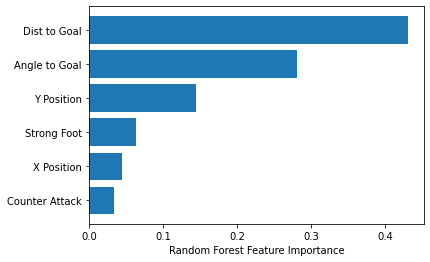

In [22]:
#sort the bar graph where the features are sorted
sorted_idx2 = rf2.feature_importances_.argsort()
sorted_idx2
feature_labels2 = feature_labels = ["Dist to Goal", "Angle to Goal", "Counter Attack", "Strong Foot", "Y Position", "X Position"]
plt.barh(np.array(feature_labels2)[sorted_idx2], rf2.feature_importances_[sorted_idx2])
plt.xlabel("Random Forest Feature Importance")
##ADD TITLE AND LABELS


No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.774


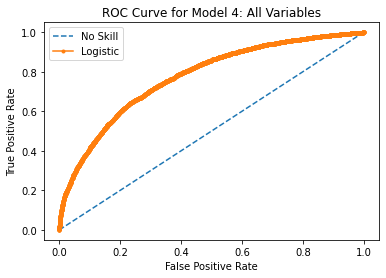

In [36]:
ns_probs = [0 for _ in range(len(y2))]
# fit a model
# predict probabilities
lr_probs = logreg2.predict_proba(X2)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y2, ns_probs)
lr_auc = roc_auc_score(y2, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y2, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y2, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('ROC Curve for Model 4: All Variables')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [24]:
#look at the probability for each area of the goal
#make a model for each subset of the data?
#bar plot of where each shot goes?

og_tags



array([list([{'id': 402}, {'id': 1401}, {'id': 1203}, {'id': 1801}]),
       list([{'id': 402}, {'id': 201}, {'id': 1216}, {'id': 1802}]),
       list([{'id': 402}, {'id': 201}, {'id': 1201}, {'id': 1801}]), ...,
       list([{'id': 401}, {'id': 2101}, {'id': 1802}]),
       list([{'id': 401}, {'id': 201}, {'id': 1204}, {'id': 1801}]),
       list([{'id': 402}, {'id': 201}, {'id': 1216}, {'id': 1802}])],
      dtype=object)

In [25]:
#!pip install mplsoccer

In [26]:
from mplsoccer.pitch import Pitch
import seaborn as sns
from mplsoccer import VerticalPitch, Standardizer, FontManager
from mplsoccer.statsbomb import read_event, EVENT_SLUG



wyscout_to_statsbomb = Standardizer(pitch_from='wyscout', pitch_to='statsbomb')
# transform the coordinates and save to the dataframe
x_std, y_std = wyscout_to_statsbomb.transform(euros_shots_joined.x,
                                              euros_shots_joined.y)
euros_shots_joined['coordinates_x'] = x_std
euros_shots_joined['coordinates_y'] = y_std

#convert the data to match the mplsoccer statsbomb pitch
euros_shots_joined['x'] = euros_shots_joined['x']*1.2
euros_shots_joined['y'] = euros_shots_joined['y']*.8

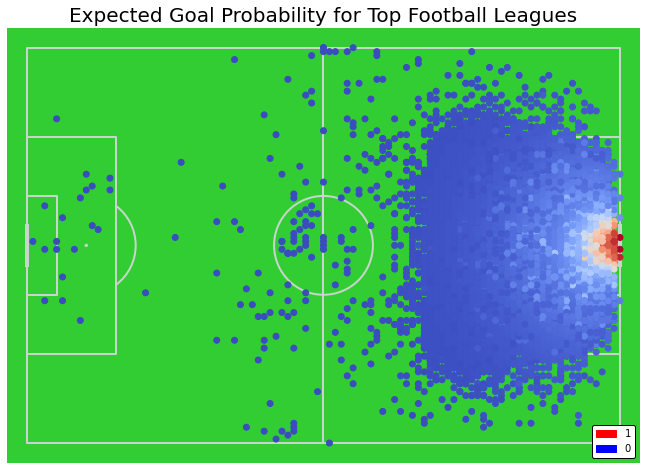

In [27]:
from mplsoccer.cm import create_transparent_cmap
fig ,ax = plt.subplots(figsize=(13.5,8))

#creating the pitch
pitch = Pitch(pitch_type='statsbomb', orientation='horizontal',
              pitch_color='#32CD32', line_color='#c7d5cc', figsize=(13, 8),
              constrained_layout=False, tight_layout=True)

#draw the pitch on the ax figure
pitch.draw(ax=ax)



sc = pitch.scatter(euros_shots_joined.x, euros_shots_joined.y,
                   cmap='coolwarm',
                   c= prob_goal,
                   ax=ax)

plt.gca().invert_yaxis()
import matplotlib.patches as mpatches


plt.title('Expected Goal Probability for Top Football Leagues',color='black',size=20)
plt.legend(handles=[mpatches.Patch(color='#FF0000', label='1'),
                    mpatches.Patch(color='#0000FF', label='0')], 
                    loc='lower right', edgecolor='black', framealpha=1)
          